# Time Series Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
df = pd.read_csv("Datasets/bitstamp.csv")
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.40,4.40,4.37,4.38,2.898606,12.679597,4.37
1,1325317980,4.41,4.43,4.40,4.42,0.809277,3.587656,4.43
2,1325318040,4.40,4.42,4.40,4.41,0.699285,3.170613,4.53
3,1325318100,4.43,4.44,4.43,4.43,1.744751,7.858554,4.50
4,1325318160,4.51,4.51,4.51,4.51,2.943349,12.427913,4.22
...,...,...,...,...,...,...,...,...
9995,1325917620,15.90,15.92,15.77,15.83,1.197659,17.694782,14.77
9996,1325917680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,1325917740,15.80,15.81,15.80,15.80,0.275508,4.460266,16.19
9998,1325917800,15.66,15.68,15.62,15.63,0.841061,13.391655,15.92


We cast the Timestamp column into a pd.Timestamp object using the pd.to_datetime.
Note: We must specify the unit for the timestamp. The defaults is ns.

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

In [5]:
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.40,4.40,4.37,4.38,2.898606,12.679597,4.37
1,2011-12-31 07:53:00,4.41,4.43,4.40,4.42,0.809277,3.587656,4.43
2,2011-12-31 07:54:00,4.40,4.42,4.40,4.41,0.699285,3.170613,4.53
3,2011-12-31 07:55:00,4.43,4.44,4.43,4.43,1.744751,7.858554,4.50
4,2011-12-31 07:56:00,4.51,4.51,4.51,4.51,2.943349,12.427913,4.22
...,...,...,...,...,...,...,...,...
9995,2012-01-07 06:27:00,15.90,15.92,15.77,15.83,1.197659,17.694782,14.77
9996,2012-01-07 06:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,2012-01-07 06:29:00,15.80,15.81,15.80,15.80,0.275508,4.460266,16.19
9998,2012-01-07 06:30:00,15.66,15.68,15.62,15.63,0.841061,13.391655,15.92


Next, we set the Timestamp column as an index for the data frame and remove it as a column.

In [6]:
df.set_index(keys=["Timestamp"], drop=True, inplace=True)
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.40,4.40,4.37,4.38,2.898606,12.679597,4.37
2011-12-31 07:53:00,4.41,4.43,4.40,4.42,0.809277,3.587656,4.43
2011-12-31 07:54:00,4.40,4.42,4.40,4.41,0.699285,3.170613,4.53
2011-12-31 07:55:00,4.43,4.44,4.43,4.43,1.744751,7.858554,4.50
2011-12-31 07:56:00,4.51,4.51,4.51,4.51,2.943349,12.427913,4.22
...,...,...,...,...,...,...,...
2012-01-07 06:27:00,15.90,15.92,15.77,15.83,1.197659,17.694782,14.77
2012-01-07 06:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-07 06:29:00,15.80,15.81,15.80,15.80,0.275508,4.460266,16.19


We always sort the time series in an ascending order (from the past to the future).

In [7]:
df.sort_index(inplace=True)

In [10]:
df.isnull().sum()

Open                 810
High                 810
Low                  810
Close                810
Volume_(BTC)         810
Volume_(Currency)    810
Weighted_Price       810
dtype: int64

We interpolate the missing values using a linear interpolation.

In [11]:
df.interpolate(inplace=True)

In [12]:
df.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

<Axes: >

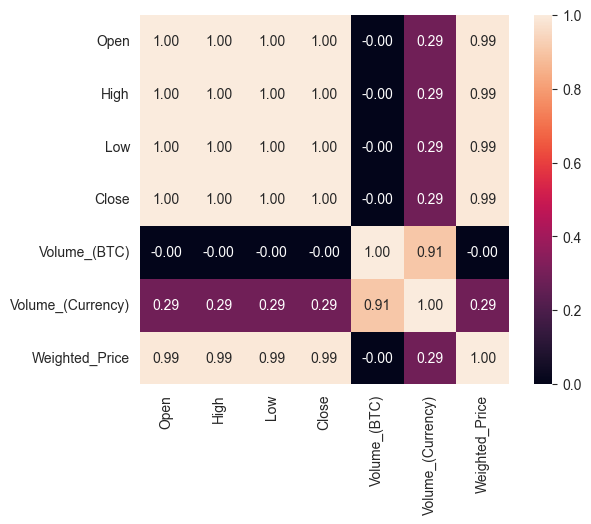

In [13]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", square=True)

In [15]:
df = df[["Close"]].copy(deep=True)
df

,Close
Timestamp,
2011-12-31 07:52:00,4.380
2011-12-31 07:53:00,4.420
2011-12-31 07:54:00,4.410
2011-12-31 07:55:00,4.430
2011-12-31 07:56:00,4.510
...,...
2012-01-07 06:27:00,15.830
2012-01-07 06:28:00,15.815
2012-01-07 06:29:00,15.800


In [16]:
lag = 3

In [18]:
periods = range(lag, 0, -1) # 3, 2, 1
periods

range(3, 0, -1)

In [22]:
df.shift(periods)

,Close_3,Close_2,Close_1
Timestamp,,,
2011-12-31 07:52:00,NaN,NaN,NaN
2011-12-31 07:53:00,NaN,NaN,4.380
2011-12-31 07:54:00,NaN,4.380,4.420
2011-12-31 07:55:00,4.380,4.420,4.410
2011-12-31 07:56:00,4.420,4.410,4.430
...,...,...,...
2012-01-07 06:27:00,15.860,15.940,15.640
2012-01-07 06:28:00,15.940,15.640,15.830
2012-01-07 06:29:00,15.640,15.830,15.815


In [23]:
df = pd.concat([df, df.shift(periods=periods)], axis=1)

In [24]:
df

,Close,Close_3,Close_2,Close_1
Timestamp,,,,
2011-12-31 07:52:00,4.380,NaN,NaN,NaN
2011-12-31 07:53:00,4.420,NaN,NaN,4.380
2011-12-31 07:54:00,4.410,NaN,4.380,4.420
2011-12-31 07:55:00,4.430,4.380,4.420,4.410
2011-12-31 07:56:00,4.510,4.420,4.410,4.430
...,...,...,...,...
2012-01-07 06:27:00,15.830,15.860,15.940,15.640
2012-01-07 06:28:00,15.815,15.940,15.640,15.830
2012-01-07 06:29:00,15.800,15.640,15.830,15.815


In [25]:
df.dropna(inplace=True)

In [26]:
X, y = df.drop(columns=["Close"]), df[["Close"]]

In [27]:
X

,Close_3,Close_2,Close_1
Timestamp,,,
2011-12-31 07:55:00,4.380,4.420,4.410
2011-12-31 07:56:00,4.420,4.410,4.430
2011-12-31 07:57:00,4.410,4.430,4.510
2011-12-31 07:58:00,4.430,4.510,4.480
2011-12-31 07:59:00,4.510,4.480,4.480
...,...,...,...
2012-01-07 06:27:00,15.860,15.940,15.640
2012-01-07 06:28:00,15.940,15.640,15.830
2012-01-07 06:29:00,15.640,15.830,15.815


In [28]:
y

,Close
Timestamp,
2011-12-31 07:55:00,4.430
2011-12-31 07:56:00,4.510
2011-12-31 07:57:00,4.480
2011-12-31 07:58:00,4.480
2011-12-31 07:59:00,4.540
...,...
2012-01-07 06:27:00,15.830
2012-01-07 06:28:00,15.815
2012-01-07 06:29:00,15.800


In [29]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, shuffle=False)

In [30]:
init_train_X, init_train_y = train_X.copy(), train_y.copy()
init_val_X, init_val_y = val_X.copy(), val_y.copy()
init_test_X, init_test_y = test_X.copy(), test_y.copy()

In [31]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)

In [32]:
train_X.shape

(6397, 3)

In [33]:
test_X.shape

(2000, 3)

In [34]:
val_X.shape

(1600, 3)

In [35]:
(train_X.shape[0], lag, (train_X.shape[1] // lag)) # (samples, timesteps, features)

(6397, 3, 1)

In [36]:
train_X = train_X.reshape(train_X.shape[0], lag, (train_X.shape[1] // lag))
val_X = val_X.reshape(val_X.shape[0], lag, (val_X.shape[1] // lag))
test_X = test_X.reshape(test_X.shape[0], lag, (test_X.shape[1] // lag))

In [37]:
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32)

val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y.to_numpy(), dtype=torch.float32)

test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32)

In [38]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN Time Series Forecaster

In [40]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1) # (samples, timesteps, features) -> (samples, features, timesteps)
        return self.net(x)

In [41]:
model = CNNRegressor()
model

CNNRegressor(
  (net): Sequential(
    (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [42]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [43]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss = 0
    for features, targets in dataloader:
        features, targets = features, targets

        optimizer.zero_grad()

        outputs = model(features)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss

In [44]:
def evaluate(model, dataloader, loss_fn):
    model.eval()

    total_loss, predictions = 0, []
    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features, targets

            outputs = model(features)
            loss = loss_fn(outputs, targets)

            predictions.extend(outputs.squeeze(1).tolist())

            total_loss += loss.item()

    return total_loss, predictions

In [45]:
num_epochs = 16

In [46]:
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss, pred_y = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        mape = mean_absolute_percentage_error(val_y.tolist(), pred_y)

        if epoch % 2 == 0:
            print(f"Epoch {epoch:3d}/{num_epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} mape={mape:.4f}")

    return train_losses, val_losses

In [47]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Epoch   2/16 | train_loss=1709.3797 val_loss=62.1390 mape=0.1097
Epoch   4/16 | train_loss=417.7443 val_loss=28.6986 mape=0.0730
Epoch   6/16 | train_loss=264.1694 val_loss=14.7862 mape=0.0528
Epoch   8/16 | train_loss=150.2223 val_loss=8.2301 mape=0.0413
Epoch  10/16 | train_loss=87.4359 val_loss=5.9649 mape=0.0365
Epoch  12/16 | train_loss=49.9422 val_loss=3.7598 mape=0.0293
Epoch  14/16 | train_loss=30.3246 val_loss=2.0254 mape=0.0210
Epoch  16/16 | train_loss=20.1399 val_loss=1.4037 mape=0.0171


<Axes: >

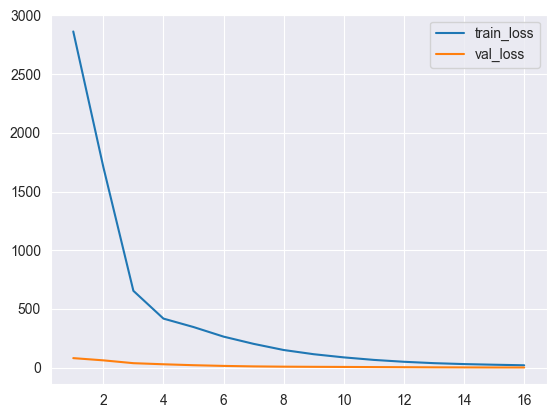

In [48]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [49]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn)

In [50]:
print(f"MAE: {mean_absolute_error(test_y, init_test_X['Close_1'])}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, init_test_X['Close_1'])}")
print(f"MSE: {mean_squared_error(test_y, init_test_X['Close_1'])}")
print(f"RMSE: {root_mean_squared_error(test_y, init_test_X['Close_1'])}")
print(f"R2 Score: {r2_score(test_y, init_test_X['Close_1'])}")

MAE: 0.11162001180648803
MAPE: 0.007898543230299806
MSE: 0.0200752090665361
RMSE: 0.14168701093091102
R2 Score: 0.9967020388840754


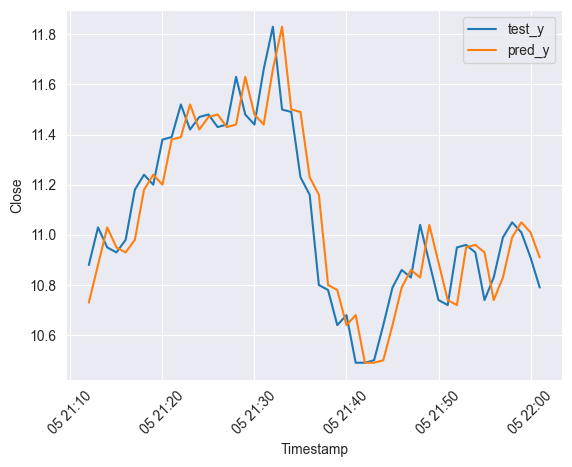

In [51]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=init_test_X["Close_1"][:50], label="pred_y")
plt.xticks(rotation=45);

In [52]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 0.24849907779693603
MAPE: 0.0167493638729417
MSE: 0.09370099185988692
RMSE: 0.3061061774284977
R2 Score: 0.9846067741235832


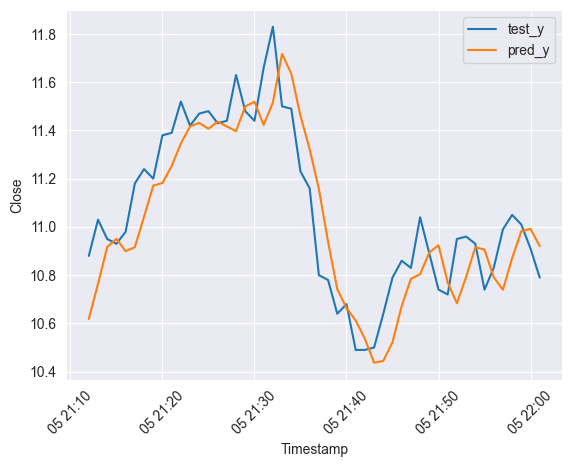

In [53]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=pred_y[:50], label="pred_y")
plt.xticks(rotation=45);

## LSTM Time-Series Forecaster

In [54]:
class LSTMRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=16, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=16, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        return self.fc(x)

In [56]:
model = LSTMRegressor()
model

LSTMRegressor(
  (lstm1): LSTM(1, 16, batch_first=True)
  (lstm2): LSTM(16, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [57]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
num_epochs = 32

In [59]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Epoch   2/32 | train_loss=9968.9081 val_loss=52.3857 mape=0.0929
Epoch   4/32 | train_loss=4528.8437 val_loss=261.2428 mape=0.2647
Epoch   6/32 | train_loss=2589.2780 val_loss=17.0463 mape=0.0671
Epoch   8/32 | train_loss=979.1189 val_loss=0.9482 mape=0.0132
Epoch  10/32 | train_loss=514.3913 val_loss=1.4168 mape=0.0164
Epoch  12/32 | train_loss=304.7682 val_loss=4.0905 mape=0.0289
Epoch  14/32 | train_loss=220.5475 val_loss=5.6563 mape=0.0340
Epoch  16/32 | train_loss=184.4147 val_loss=5.2804 mape=0.0324
Epoch  18/32 | train_loss=145.4305 val_loss=3.7117 mape=0.0268
Epoch  20/32 | train_loss=97.9272 val_loss=2.3776 mape=0.0215
Epoch  22/32 | train_loss=63.6978 val_loss=1.6153 mape=0.0180
Epoch  24/32 | train_loss=43.8726 val_loss=1.0578 mape=0.0143
Epoch  26/32 | train_loss=33.5795 val_loss=0.8328 mape=0.0124
Epoch  28/32 | train_loss=27.2955 val_loss=0.7169 mape=0.0114
Epoch  30/32 | train_loss=22.0720 val_loss=0.6266 mape=0.0105
Epoch  32/32 | train_loss=18.3709 val_loss=0.6969 mape

In [60]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn)

<Axes: >

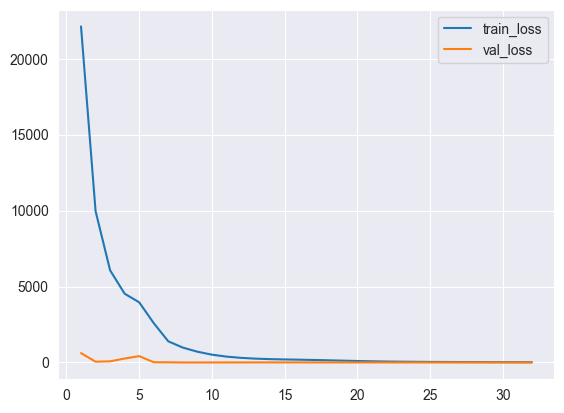

In [61]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [62]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 0.2245679488182068
MAPE: 0.015238712525875133
MSE: 0.07814631649418743
RMSE: 0.2795466266907677
R2 Score: 0.9871621006637397


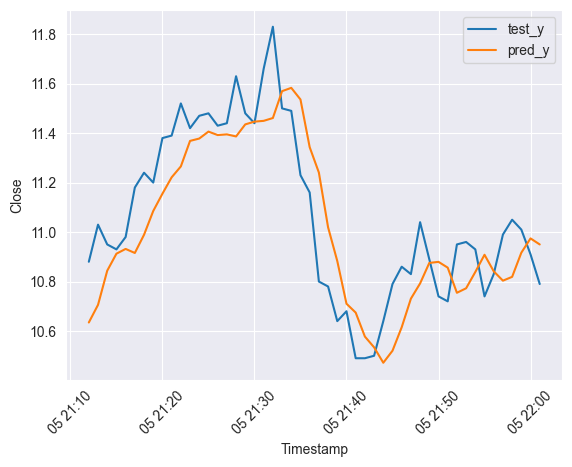

In [64]:
sns.lineplot(x=init_test_y.index[:50], y=init_test_y["Close"][:50], label="test_y")
sns.lineplot(x=init_test_y.index[:50], y=pred_y[:50], label="pred_y")
plt.xticks(rotation=45);